In [1]:
import requests
from csv import reader

In [2]:
from pprint import pprint

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams["font.size"] = 35
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams.update({'font.size': 40})

## Download Data

In [5]:
TAGS = ['current+best', 
        'epoch', 
        'multi-acc-test/class+0',
        'multi-acc-test/class+1',
        'multi-acc-test/class+2',
        'multi-acc-test/class+3',
        'multi-acc-test/class+4',
        'multi-acc-test/class+5',
        'multi-acc-test/class+6',
        'multi-acc-test/class+7',
        'multi-acc-test/class+8',
        'multi-acc-test/class+9',
        'multi-acc-val/class+0',
        'multi-acc-val/class+1',
        'multi-acc-val/class+2',
        'multi-acc-val/class+3',
        'multi-acc-val/class+4',
        'multi-acc-val/class+5',
        'multi-acc-val/class+6',
        'multi-acc-val/class+7',
        'multi-acc-val/class+8',
        'multi-acc-val/class+9',
        'test/accuracy',
        'test/jaccard+score',
        'test/loss',
        'train loss',
        'val/accuracy',
        'val/jaccard+score',
        'val/loss']

RUNS = [
        'BritTrainB', 'BritTrainC', 'BritTrainE',
        'BonnTrainB', 'BonnTrainC', 'BonnTrainE',
        'RawTrainA', 'RawTrainB', 'RawTrainC'
        ]

In [6]:
def get_data(tag, run):
    url = f'http://localhost:6006/experiment/defaultExperimentId/data/plugin/scalars/scalars?tag={tag}&run={run}&format=csv'
    r = requests.get(url, allow_redirects=True)
    data_csv = reader(r.text.splitlines())
    data = list(data_csv)
    return [x[1] for x in data[1:]], [x[2] for x in data[1:]]

In [7]:
def get_timeseries(tag, runs=RUNS):
    data = []
    for run in runs:
        steps, values = get_data(tag, run)
        data.append([float(x) for x in values])
    
    return [float(x) for x in steps], data

In [8]:
def average(data):
    avg_data = []
    for i in range(0, len(data), 3):
        avg_data.append(np.mean(data[i:i+3], axis=0))
    return avg_data

In [9]:
def smoothing(data, alpha=.99):
    smoothed_data = []
    for item in data:
        smoothed = []
        curr = item[0]
        for t in item:
            curr = alpha * curr + (1-alpha) * t
            smoothed.append(curr)
        
        smoothed_data.append(smoothed)
    return smoothed_data

In [10]:
def smoothing2(data, size=100):
    smoothed_data = []
    for item in data:
        smoothed = []
        for i in range(len(item)):
            smoothed.append(np.mean(item[max(0, i-50): i]))
        
        smoothed_data.append(smoothed)
    return smoothed_data

## epochs

In [11]:
STEPS, EPOCHS = get_timeseries('epoch')

## plotting

In [12]:
def plot(steps, front, back, title='PLOT', labels=RUNS):
    
    front_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    back_colors = ['lightsteelblue', 'peachpuff', 'palegreen', 'tab:red', 'tab:purple']
        
    for i, item in enumerate(back):
        plt.plot(steps, item, color=back_colors[int(i/3)])
        
    for i, item in enumerate(front):
        plt.plot(steps, item, label=labels[i], color=front_colors[i])
    
    plt.title(title)
    plt.xticks(range(0, int(steps[-1])+1, int(steps[-1]/20)), range(0, 101, 5))
    
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(f"{title.replace(' ', '')}.pdf", bbox_inches='tight')

## train loss

In [13]:
steps, data = get_timeseries('train+loss', runs=RUNS[3:])
print(len(steps))
print(len(data[0]))

1000
1000


2 (1000,)
[nan, 0.42020554343859357, 0.3531348382433256, 0.34671357439623945, 0.36401594306031865, 0.3553906669219335, 0.34401850485139424, 0.33499619435696376, 0.3323589861392975, 0.33570243418216705]
[nan, 0.9636009335517883, 0.8706331253051758, 0.6966159062253104, 0.6640354059636593, 0.6770451873540878, 0.656448509130213, 0.6228240082661312, 0.6073293791462978, 0.5841918471786711]


/home/nikki/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nikki/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


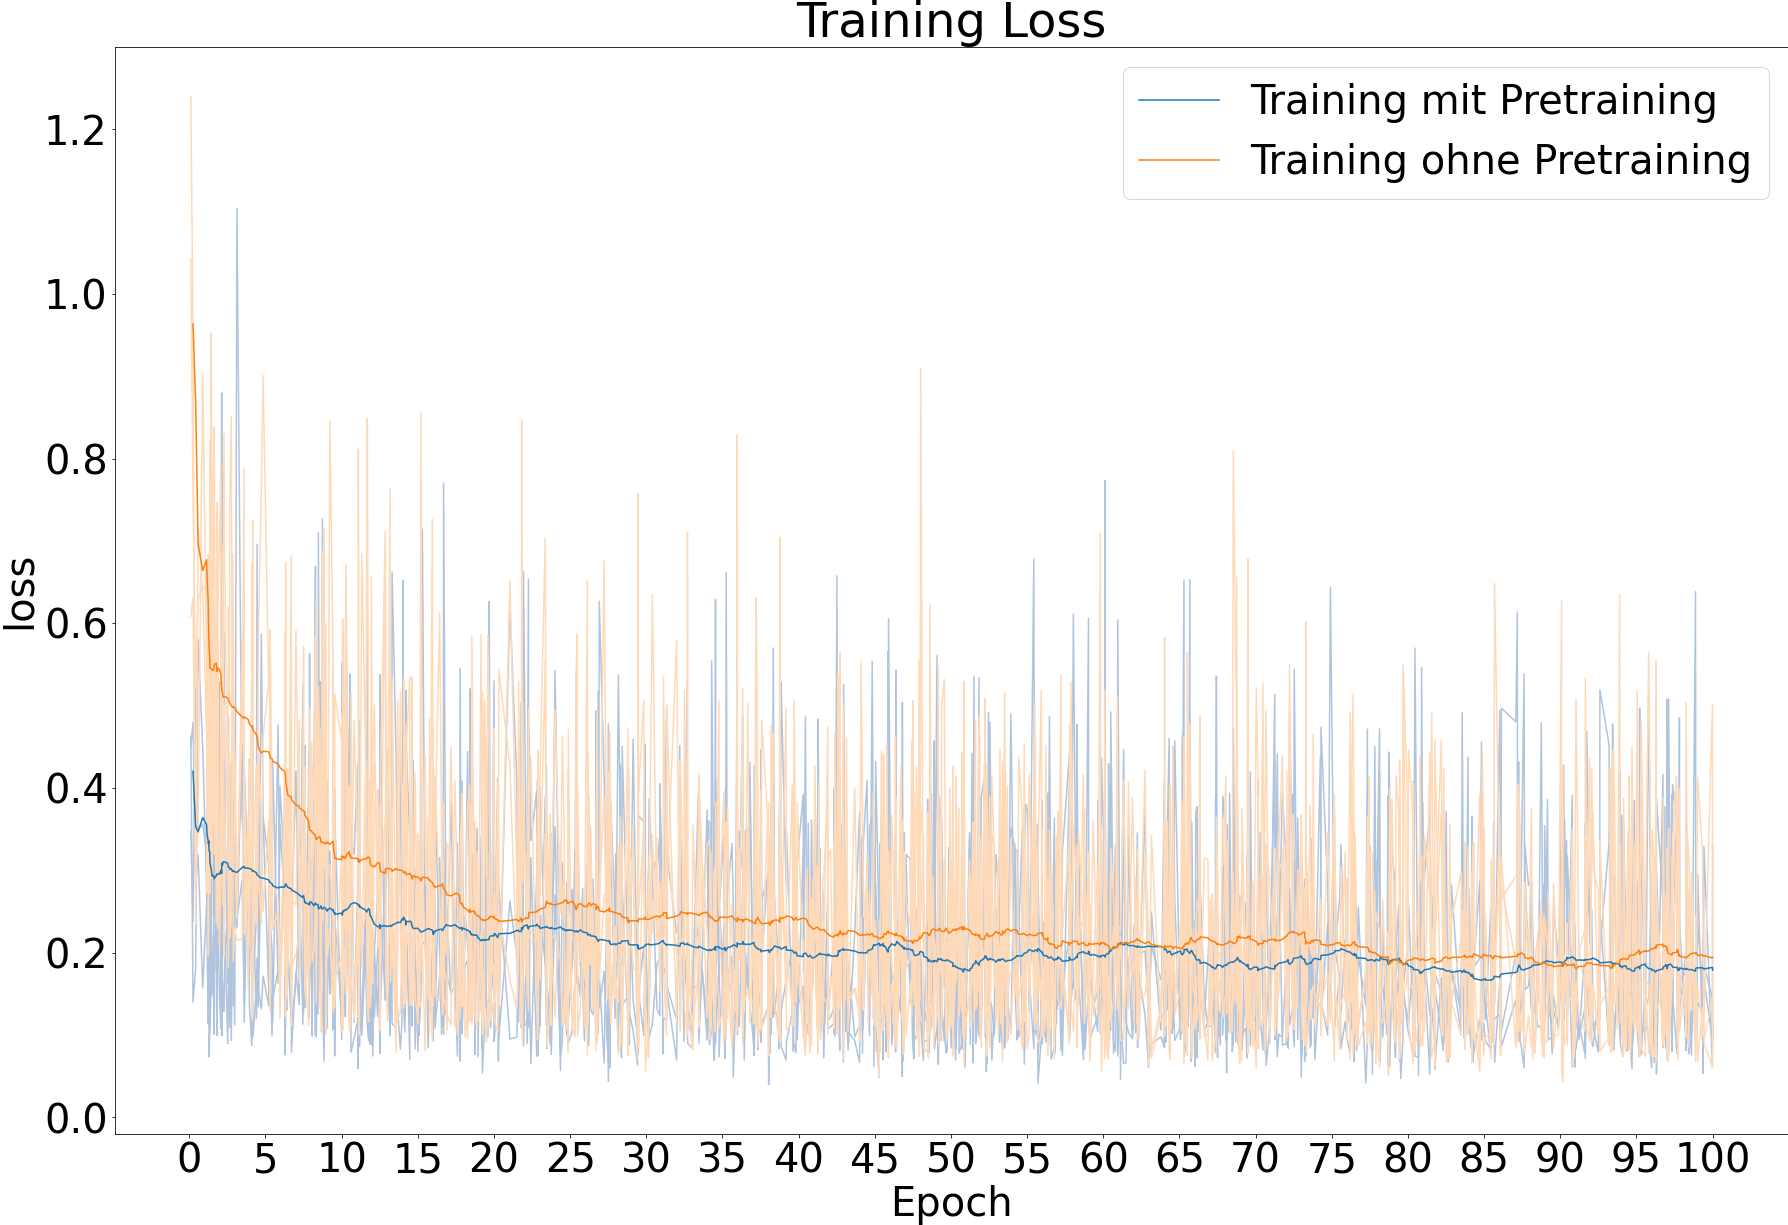

In [14]:
data_mean = average(data)
print(len(data_mean), data_mean[0].shape)
smoothed = smoothing2(data_mean)
print(smoothed[0][:10])
print(smoothed[1][:10])
plot(steps, smoothed, data, title='Training Loss', labels=['Training mit Pretraining', 'Training ohne Pretraining'])

## val loss

In [15]:
steps, data = get_timeseries('val/loss', runs=RUNS[3:])
print(len(steps))
print(len(data))

187
6


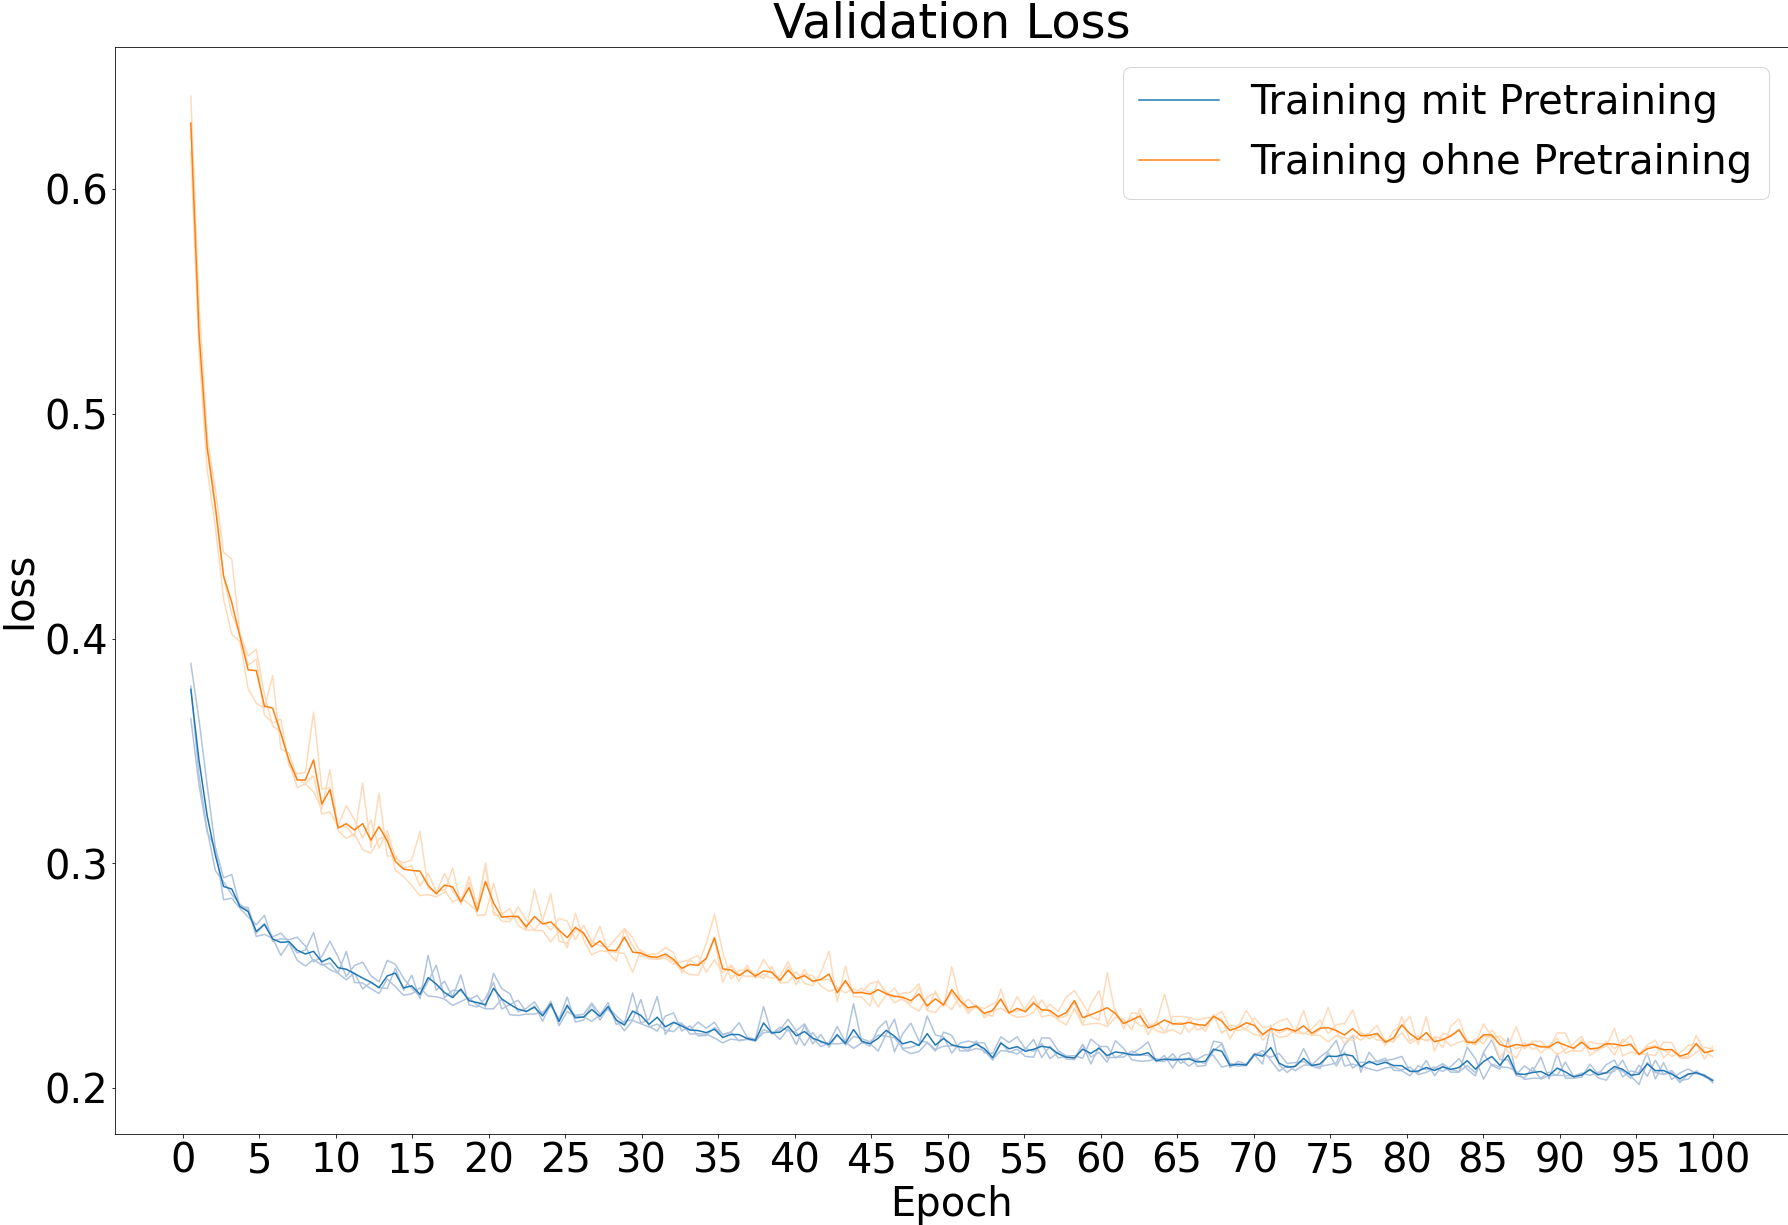

In [16]:
data_mean = average(data)
# smoothed = smoothing(data_mean, alpha=.7)
plot(steps, data_mean, data, title='Validation Loss', labels=['Training mit Pretraining', 'Training ohne Pretraining'])

## Val Acc

In [17]:
steps, data = get_timeseries('val/accuracy', runs=RUNS[3:])
print(len(steps))
print(len(data))

187
6


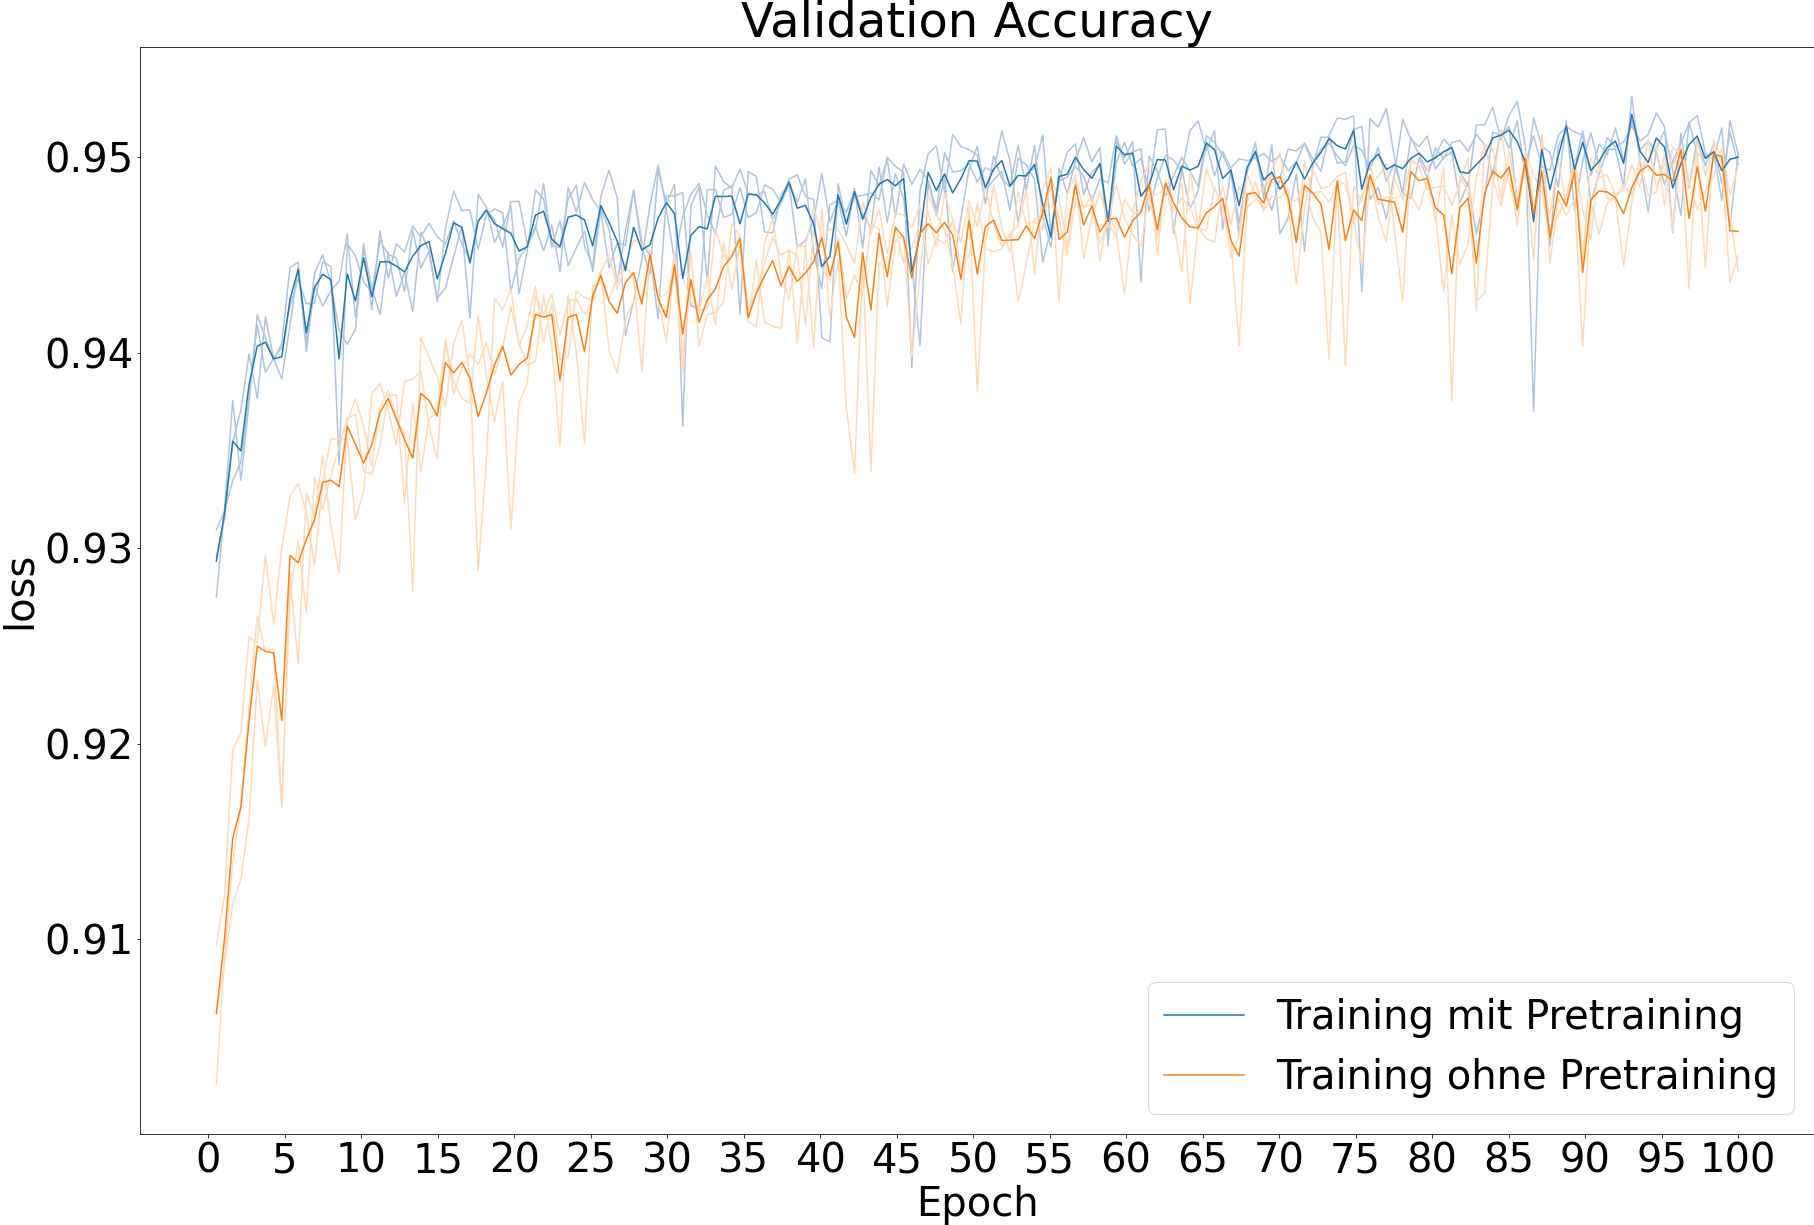

In [18]:
data_mean = average(data)
# smoothed = smoothing(data_mean, alpha=.7)
plot(steps, data_mean, data, title='Validation Accuracy', labels=['Training mit Pretraining', 'Training ohne Pretraining'])

## test

In [19]:
steps, data = get_timeseries('test/accuracy')
data = np.array(data).reshape(-1)

print(np.mean(data[0:3]))

pprint(data)

0.8773864905039469
array([0.87988698, 0.8796373 , 0.87263519, 0.95319498, 0.95183331,
       0.95183074, 0.94946766, 0.94998318, 0.94848901])


## Loss Vergleich

In [20]:
val_steps, val_data = get_timeseries('val/loss', runs=RUNS[3:6])
train_steps, train_data = get_timeseries('train+loss', runs=RUNS[3:6])

In [21]:
val_mean = np.mean(val_data, axis=0)
train_mean = np.mean(np.array(smoothing2(train_data)), axis=0)

print(val_mean.shape, len(val_steps))
print(len(train_mean), len(train_steps))
print(train_mean[:10])

(187,) 187
1000 1000
[       nan 0.42020554 0.35313484 0.34671357 0.36401594 0.35539067
 0.3440185  0.33499619 0.33235899 0.33570243]


/home/nikki/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nikki/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


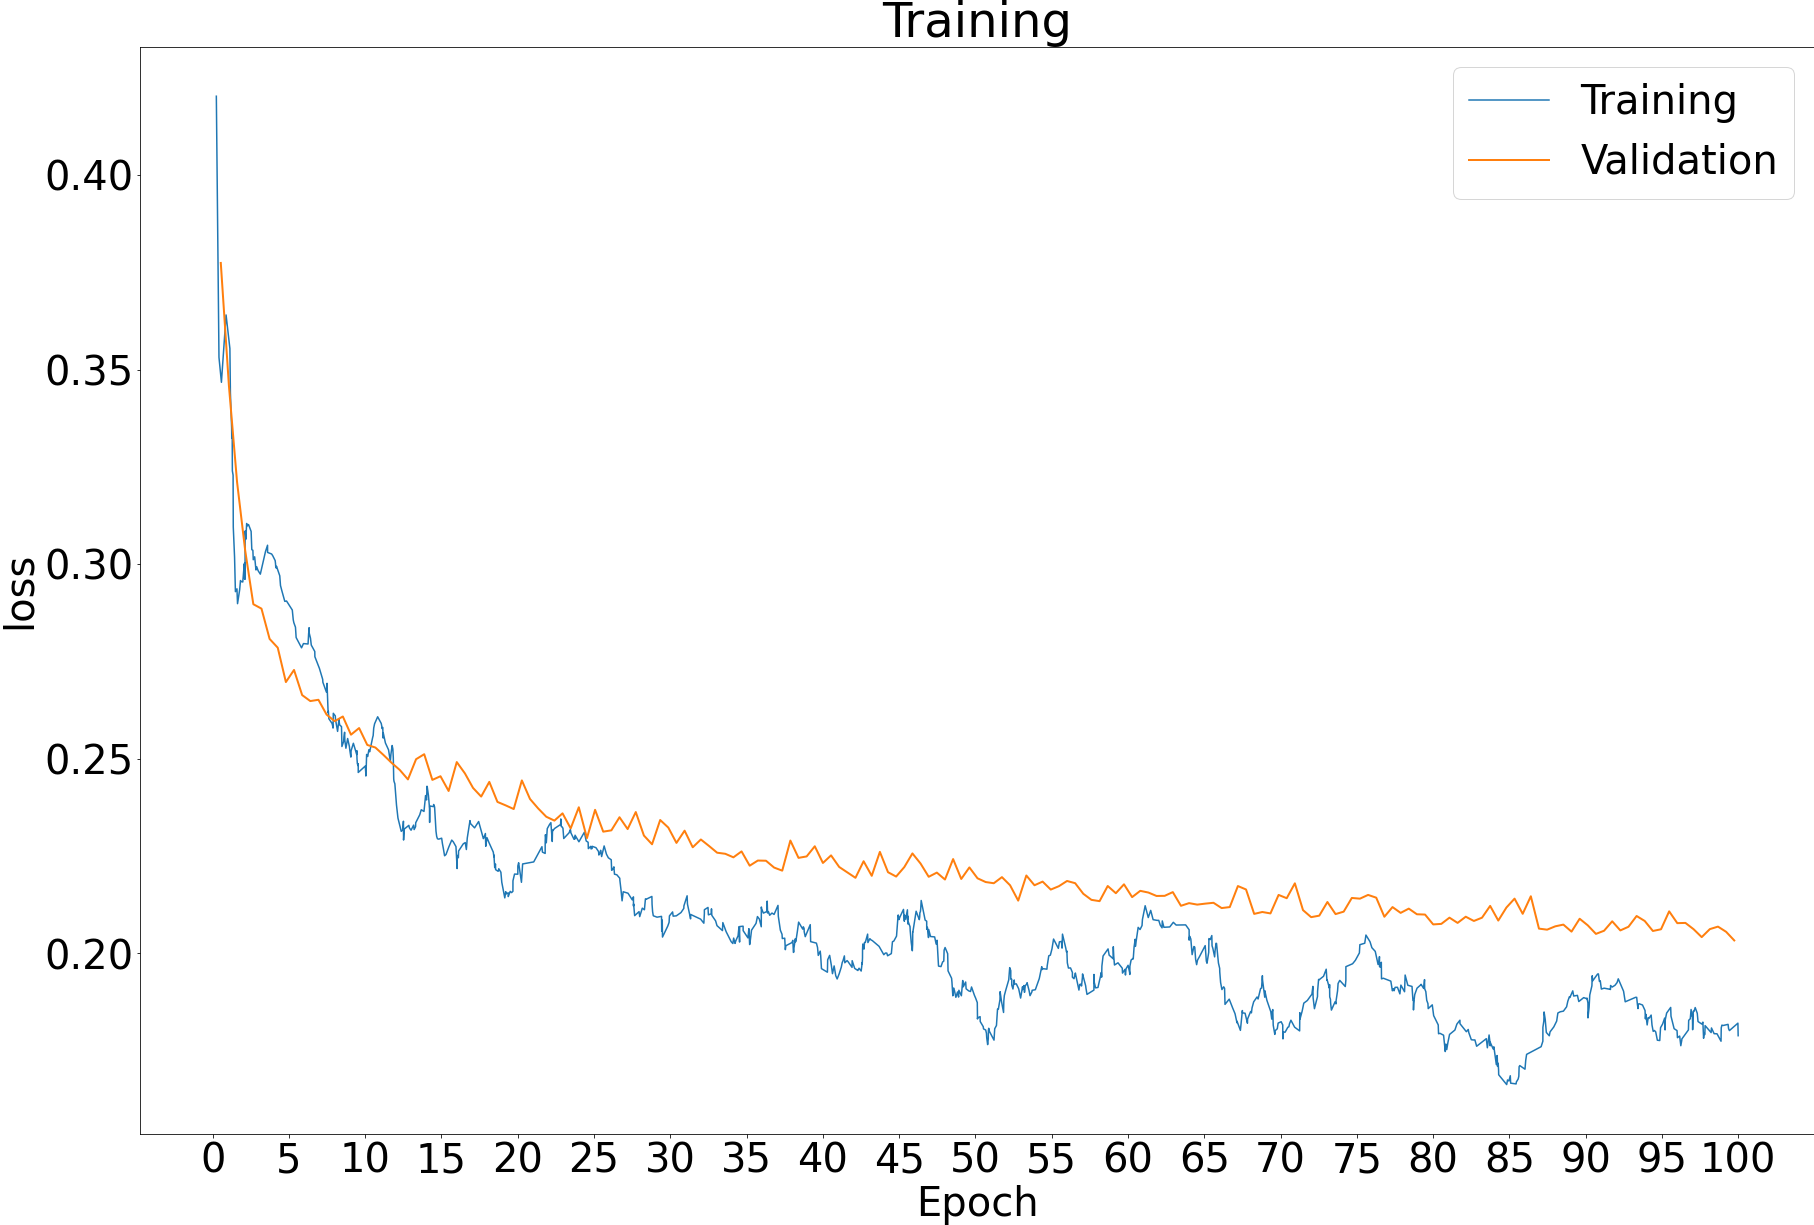

In [22]:
plt.plot(train_steps, train_mean, label='Training')
plt.plot(val_steps, val_mean, label='Validation', linewidth=2)

plt.xticks(range(0, int(steps[-1])+1, int(steps[-1]/20)), range(0, 101, 5))

plt.title('Training')

plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend()
plt.savefig("TrainingBonn.pdf", bbox_inches='tight')

In [23]:
val_steps, val_data = get_timeseries('val/loss', runs=RUNS[:3])
train_steps, train_data = get_timeseries('train+loss', runs=RUNS[:3])

In [24]:
val_mean = np.mean(val_data, axis=0)
train_mean = np.mean(np.array(smoothing2(train_data)), axis=0)

print(val_mean.shape, len(val_steps))
print(train_mean.shape, len(train_steps))


(201,) 201
(1000,) 1000


/home/nikki/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nikki/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


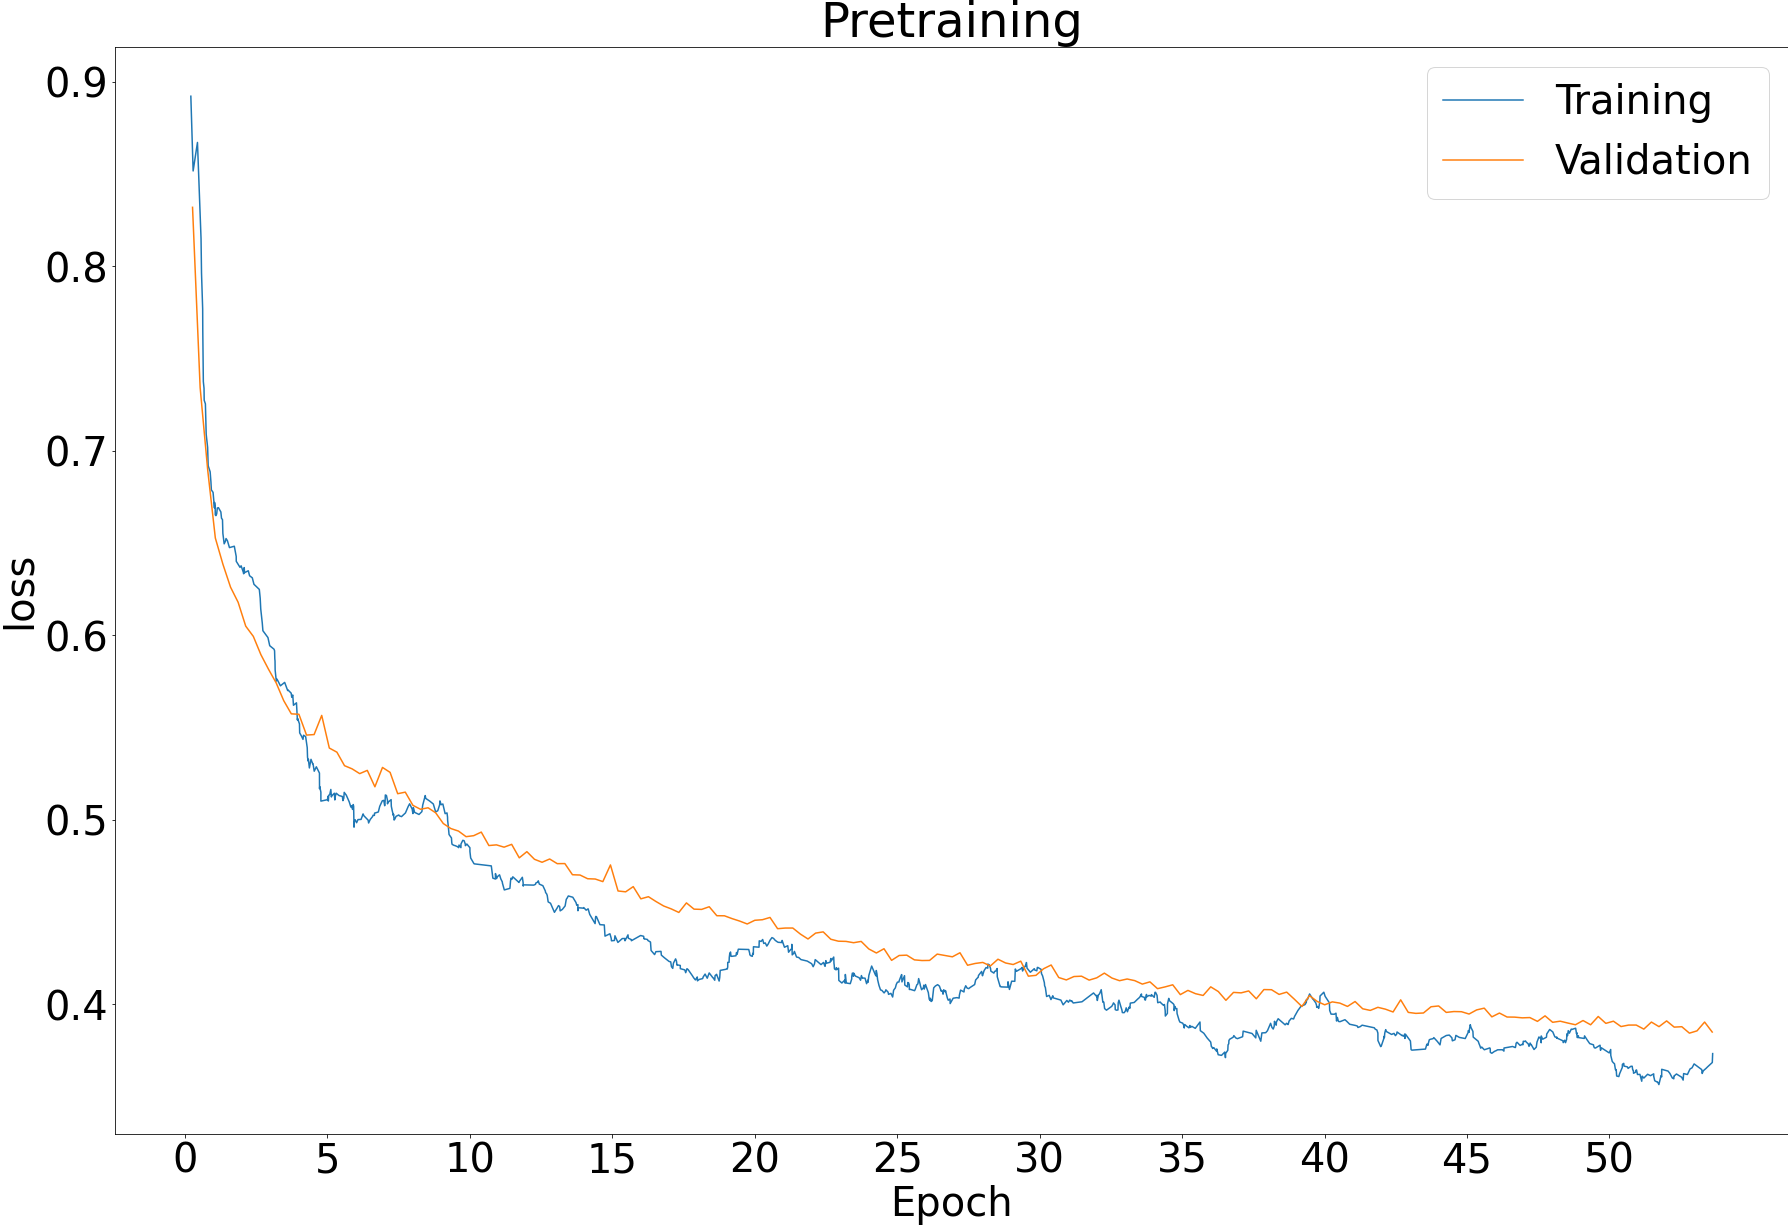

In [25]:
plt.plot(train_steps, train_mean, label='Training')
plt.plot(val_steps, val_mean, label='Validation')

plt.xticks(range(0, int(steps[-1])+1, int(steps[-1]/10)), range(0, 51, 5))

plt.title('Pretraining')

plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend()
plt.savefig("TrainingBrit.png", bbox_inches='tight')

## Klassen

In [26]:
plt.rcParams['savefig.pad_inches'] = 2
plt.rcParams.update({'figure.autolayout': True})

In [27]:
classes = ['multi-acc-test/class+0',
        'multi-acc-test/class+1',
        'multi-acc-test/class+2',
        'multi-acc-test/class+3',
        'multi-acc-test/class+4',
        'multi-acc-test/class+5',
        'multi-acc-test/class+6',
        'multi-acc-test/class+7',
        'multi-acc-test/class+8',
        'multi-acc-test/class+9']

LABEL_ASSIGNMENTS = ["Background", "UnknownRegion", "Caption", "Table", "Article", "Heading", "Header",
                     "Separator (vertical)", "Separator (short)", "Separator (horizontal)"]

In [28]:
resultsPretraining = {}
resultsRaw = {}
for i, region in enumerate(classes):
    _, data = get_timeseries(region)
    resultsPretraining[LABEL_ASSIGNMENTS[i]] = {'mean': np.mean([data[i][0] for i in range(3)]), 'std': np.std([data[i][0] for i in range(3)])}
    resultsRaw[LABEL_ASSIGNMENTS[i]] = {'mean': np.mean([data[i][0] for i in range(3, 6)]), 'std': np.std([data[i][0] for i in range(3, 6)])}
    
pprint(resultsPretraining)
pprint(resultsRaw)

IndexError: list index out of range

In [ ]:
plt.bar(np.arange(10)-.21, [x['mean'] for x in resultsPretraining.values()], yerr=[x['std'] for x in resultsPretraining.values()], width=.4, label='mit Pretraining', capsize=18)
plt.bar(np.arange(10)+.21, [x['mean'] for x in resultsRaw.values()], yerr=[x['std'] for x in resultsRaw.values()], width=.4, label='ohne Pretraining', capsize=18)

plt.legend()
plt.xticks(np.arange(10), resultsPretraining.keys(), rotation=70)
plt.xlabel('Region')
plt.ylabel('Accuracy')


plt.autoscale()
plt.savefig("ClassAcc.pdf")